# Preparation notebook

For this notebook execution, i assume you have downloaded the complete Open Food Fact CSV export (link in README file) in ./datas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

%matplotlib inline

import re

***
# Application concept: Foodprint
## Description
Foodprint give carbon footprint and nutri score of a product, by scanning them.
The carbon footprint information is given through a new value, the Carbon-Score, or C-Score.
This C-Score is calculated with:
- product's origin
- country where process/transformation on the product has been done
- origin of the packaging
- packaging's materials
- purchase place
- ingredients (those who may be nocive to environment, by their culture or transformation)

Those metrics will help people to eat better and in a way better manner for the environment.

## Making the difference
Foodprint will not only give you C-Score and NutriScore for each product you scan, but you will have also the metrics for the brand of this product.
More specifically you will have ( for the C-Score and NutriScore)
- the average scores oof all the brand's products
- the worst scores of this brand's product
- the greater scores of this brand's product
- the number of products beyond the average score, and percentage
- total number of product

Thoses metrics will help people to consume better and force the big companies to make more effort.

## Useful fields

In [5]:
usecols = [
    "code",
    "url",
    "product_name",
    "brands",
    "categories_en",
    "origins_en",
    "manufacturing_places",
    "countries",
    "nutriscore_grade",
    #"image_url",
    "image_small_url"
]

In [6]:
data = pd.DataFrame()

types = {
    "code": np.string_,
    "emb_codes": np.string_,
    "first_packaging_code_geo": np.string_,
    "cities_tags": np.string_,
}

for chunk in pd.read_csv("./datas/en.openfoodfacts.org.products.csv", sep="\t", skipinitialspace=True, nrows=None, chunksize=100000, dtype=types, usecols=usecols):
    chunk = chunk.dropna()
    data = pd.concat([data, chunk])
    del chunk

row_nb, col_nb = data.shape
(row_nb, col_nb)

(35475, 10)

In [7]:
data.head()

,code,url,product_name,brands,categories_en,origins_en,manufacturing_places,countries,nutriscore_grade,image_small_url
336,0000000274722,http://world-en.openfoodfacts.org/product/0000...,Blanquette de Volaille et son Riz,Comme J’aime,"Meals,Meat-based products,Meals with meat,Poul...",France,France,France,b,https://images.openfoodfacts.org/images/produc...
339,0000000290616,http://world-en.openfoodfacts.org/product/0000...,Salade Cesar,Kirkland Signature,"Plant-based foods and beverages,Plant-based fo...",fr:quebec,Brossard Québec,Canada,c,https://images.openfoodfacts.org/images/produc...
380,0000001938067,http://world-en.openfoodfacts.org/product/0000...,Chaussons tressés aux pommes,Kirkland Signature,"Snacks,Sweet snacks,Biscuits and cakes,Viennoi...",fr:quebec,Brossard Québec,Canada,c,https://images.openfoodfacts.org/images/produc...
397,0000004302544,http://world-en.openfoodfacts.org/product/0000...,Pain Burger Artisan,Kirkland Signature,fr:boulange,fr:quebec,"Brossard,Québec",Canada,b,https://images.openfoodfacts.org/images/produc...
425,0000008237798,http://world-en.openfoodfacts.org/product/0000...,Quiche Lorraine,Kirkland Signature,"Meals,Pizzas pies and quiches,Quiches,Lorraine...",fr:quebec,"Brossard,Québec",Canada,b,https://images.openfoodfacts.org/images/produc...


***
# Create a sample of 5 000 rows
## Seeding
By keeping the same seed, we ensure the randomize method will ever return the same number. We want that behavior to always have the same sample.
## Sampling
We use the randint method to generate random number corresponding to the dataset'w rows

In [13]:
np.random.seed(294697)
sample_size = 5000
sample_index = np.random.randint(row_nb, size=sample_size)
sample_index

array([ 3650, 15739, 24013, ...,  7560, 23340, 17019])

In [14]:
sample = data.iloc[sample_index]

In [15]:
sample.head()

,code,url,product_name,packaging_tags,brands,categories_en,origins_en,manufacturing_places,stores,countries,nutriscore_grade,image_url,image_small_url
681297,3022825850117,http://world-en.openfoodfacts.org/product/3022...,Cassoulet - Pur Porc,"bocal,verre,couvercle,metal,conserve",Charles Christ,"Canned foods,Meals,Meat-based products,Meals w...","France,fr:viande-de-porc",Christ (Filiale Reitzel Briand) - 65 Rue de Pa...,"Cora, Magasins U",France,a,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...
1104081,4001513007629,http://world-en.openfoodfacts.org/product/4001...,Gerolsteiner Sprudel,"pet,einwegpfand",Gerolsteiner,"Beverages,Carbonated drinks,Waters,Spring wate...","de:eifel,de:gerolstein","Gerolstein,Deutschland",Edeka,Deutschland,a,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...
1772118,8437001133314,http://world-en.openfoodfacts.org/product/8437...,Gazpacho andaluz,berlingot,Bio Arte Olivia,"Plant-based foods and beverages,Plant-based fo...",Spain,Espagne,Géant casino,"France,Nouvelle-Calédonie",b,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...
1586799,8017596101273,http://world-en.openfoodfacts.org/product/8017...,Burger di soia,"plastica,carta",fior di natura,"Sandwiches,Hamburgers",it:i,paesi bassi,Eurospin,en:it,c,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...
1886545,9300601387502,http://world-en.openfoodfacts.org/product/9300...,Butter Chicken,"plastic,cardboard",Coles,"Butter-chicken,Readymeals",Australia,Australia,"Coles,Bilo",Australia,c,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...


***
# Cleaning

# Filling
## Carbon-Score
The carbon score is scaled on the [earth half circumference](https://en.wikipedia.org/wiki/Earth%27s_circumference), ehc ~= 20 000 km.
The step of the scale is ehc / 5, step = 4 000 km

In [41]:
real_scale = np.linspace(0, 20000, 5)
real_scale

array([    0.,  5000., 10000., 15000., 20000.])

In [131]:
inter = interp1d([0, 20000], [0, 2])
inter(real_scale)

array([0. , 0.5, 1. , 1.5, 2. ])

In [132]:
x = np.exp(inter(real_scale))
x

array([1.        , 1.64872127, 2.71828183, 4.48168907, 7.3890561 ])

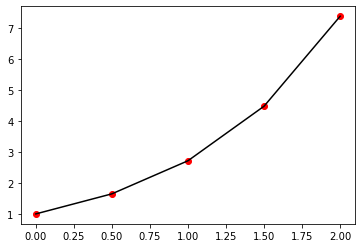

In [133]:
plt.scatter(inter(real_scale), x, color="red")
plt.plot(inter(real_scale), x, color="black")

In [134]:
from scripts.distance import Coordinate

In [135]:
coord_France = Coordinate(46.23, 2.21)
coord_Japon = Coordinate(36.2, 138.25)
coord_Grèce = Coordinate(39.07, 21.82)

print("France <-> Japon: ", coord_France.distance(coord_Japon)) # ~ 9 850 km
print("France <-> Grèce: ", coord_France.distance(coord_Grèce)) # ~ 1 894 km

France <-> Japon:  9850.392376381558
France <-> Grèce:  1783.9756419893315


***
# Writing to CSV
## Separator
We use the ';' separator because there is fields that contains a list of tags, separated by ','

In [136]:
sample.to_csv("./datas/sample.csv", sep=";")